In [ ]:
import os
import json
import gc
!pip install tensorflow

import albumentations as albu
import cv2
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Rest of your code...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(22184, 5)


,Image_Label,EncodedPixels,ImageId,ClassId,hasMask
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,False
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,True


In [ ]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(5546, 2)


<ipython-input-38-b587265b1a58>:1: FutureWarning: The operation <function sum at 0x7f2efb6403a0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()


,ImageId,hasMask
821,24dd99c.jpg,4
1885,562f80a.jpg,4
3260,944f10b.jpg,4
1872,55b539f.jpg,4
4464,cdf7242.jpg,4


In [ ]:
sub_df = pd.read_csv('/content/drive/MyDrive/sample_submission (1).csv')
sub_df['ImageId'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

In [ ]:
def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width),
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]

    mask= np.zeros( width*height ).astype(np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]

    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))

    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask

    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape

    rles = []

    for i in range(depth):
        mask = masks[:, :, i]

        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)

        rle = mask2rle(mask)
        rles.append(rle)

    return rles

In [ ]:
def visualize(image, mask, mask_prediction):
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    f, ax = plt.subplots(2, 5, figsize=(24,8))

    ax[0, 0].imshow(image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)

    ax[1, 0].imshow(image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(mask_prediction[:, :, i])
        ax[1, i + 1].set_title(f'Prediction {class_dict[i]}', fontsize=fontsize)

In [ ]:
class RAdam(keras.optimizers.Optimizer):
    """RAdam optimizer.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(min_lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                self.min_lr + (lr - self.min_lr) * (1.0 - K.minimum(t, self.total_steps) / self.total_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t) + self.epsilon)

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t >= 5, r_t * m_corr_t / v_corr_t, m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {
            'lr': float(K.get_value(self.lr)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
# def dice_coef(y_true, y_pred, smooth=1):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def dice_loss(y_true, y_pred):
#     smooth = 1.
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = y_true_f * y_pred_f
#     score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return 1. - score

def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(K.cast(y_true, 'float32'))  # Cast y_true to float32
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2.0 * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1.0 - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Rest of your code...


# Rest of your code...


In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='/content/drive/MyDrive/Trining data',
                 batch_size=32, dim=(1400, 2100), n_channels=3, reshape=None,
                 augment=False, n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state

        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]

        X = self.__generate_X(list_IDs_batch)

        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)

            if self.augment:
                X, y = self.__augment_batch(X, y)

            return X, y

        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)

    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)

            if self.reshape is not None:
                img = np_resize(img, self.reshape)

            # Store samples
            X[i,] = img #cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape((img.shape[0],img.shape[1],1))

        return X

    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)

        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]

            rles = image_df['EncodedPixels'].values

            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)

            y[i, ] = masks

        return y

    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img

    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=45, shift_limit=0.15, scale_limit=0.15)
        ])

        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']

        return aug_img, aug_masks

    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])

        return img_batch, masks_batch

    def getitem(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]

        X = self.__generate_X(list_IDs_batch)

        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)

            if self.augment:
                X, y = self.__augment_batch(X, y)

            return X, y

        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')

In [ ]:
def vanilla_unet(input_shape):
    """
    This is the old model. Best LB is ~0.5
    """
    inputs = Input(input_shape)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2), padding='same') (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2), padding='same') (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2), padding='same') (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D((2, 2), padding='same') (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D((2, 2), padding='same') (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
def vanilla_unet_crop(input_shape):
    """
    This is the old model. Best LB is ~0.5
    """
    inputs = Input(input_shape)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    #c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2), padding='same') (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    #c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2), padding='same') (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    #c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2), padding='same') (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    #c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D((2, 2), padding='same') (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    #c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D((2, 2), padding='same') (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    #c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    #c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    #c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    #c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
def vanilla_unet_downscale(input_shape):
    """
    This is the old model. Best LB is ~0.5
    """
    inputs = Input(input_shape)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2), padding='same') (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2), padding='same') (c2)

    c3 = Conv2D(16, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(16, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2), padding='same') (c3)

    c4 = Conv2D(16, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(16, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D((2, 2), padding='same') (c4)

    c5 = Conv2D(32, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(32, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D((2, 2), padding='same') (c5)

    c55 = Conv2D(64, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(64, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(32, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(32, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(16, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(16, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
def vanilla_unet_downscale_crop(input_shape):
    """
    This is the old model. Best LB is ~0.5
    """
    inputs = Input(input_shape)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    #c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2), padding='same') (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    #c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2), padding='same') (c2)

    c3 = Conv2D(16, (3, 3), activation='elu', padding='same') (p2)
    #c3 = Conv2D(16, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2), padding='same') (c3)

    c4 = Conv2D(16, (3, 3), activation='elu', padding='same') (p3)
    #c4 = Conv2D(16, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D((2, 2), padding='same') (c4)

    c5 = Conv2D(32, (3, 3), activation='elu', padding='same') (p4)
    #c5 = Conv2D(32, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D((2, 2), padding='same') (c5)

    c55 = Conv2D(64, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(64, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(32, (3, 3), activation='elu', padding='same') (u6)
    #c6 = Conv2D(32, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(16, (3, 3), activation='elu', padding='same') (u7)
    #c7 = Conv2D(16, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    #c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    #c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
BATCH_SIZE = 32

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.2
)

train_generator = DataGenerator(
    train_idx,
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    reshape=(320, 480),
    augment=True,
    n_channels=3,
    n_classes=4
)

val_generator = DataGenerator(
    val_idx,
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    reshape=(320, 480),
    augment=False,
    n_channels=3,
    n_classes=4
)

check_generator = DataGenerator(
    val_idx[0:10],
    df=mask_count_df,
    mode='predict',
    shuffle=False,
    reshape=(320, 480),
    augment=False,
    n_channels=3,
    n_classes=4,
    batch_size=1,
)

In [ ]:
model = vanilla_unet((320, 480,3))

model.compile(optimizer=Nadam(lr=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 320, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_92 (Conv2D)             (None, 320, 480, 8)  224         ['input_5[0][0]']                
                                                                                                  
 conv2d_93 (Conv2D)             (None, 320, 480, 8)  584         ['conv2d_92[0][0]']              
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 160, 240, 8)  0          ['conv2d_93[0][0]']        

In [ ]:
%%time
checkpoint = ModelCheckpoint('model_0.h5', save_best_only=True)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    epochs=3
)

<timed exec>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/3
138/138 [==============================] - 6928s 50s/step - loss: 1.4193 - dice_coef: 0.8120 - val_loss: 1.2561 - val_dice_coef: 0.8234
Epoch 2/3
138/138 [==============================] - 619s 4s/step - loss: 1.2254 - dice_coef: 0.7979 - val_loss: 1.2006 - val_dice_coef: 0.7890
Epoch 3/3
138/138 [==============================] - 625s 5s/step - loss: 1.1973 - dice_coef: 0.7771 - val_loss: 1.1773 - val_dice_coef: 0.7572
CPU times: user 27min 19s, sys: 5min 40s, total: 32min 59s
Wall time: 2h 16min 58s


<Axes: >

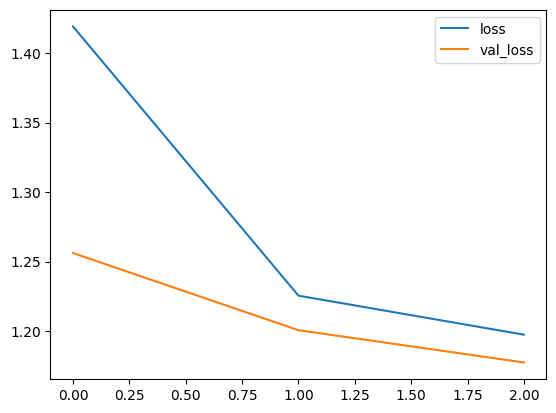

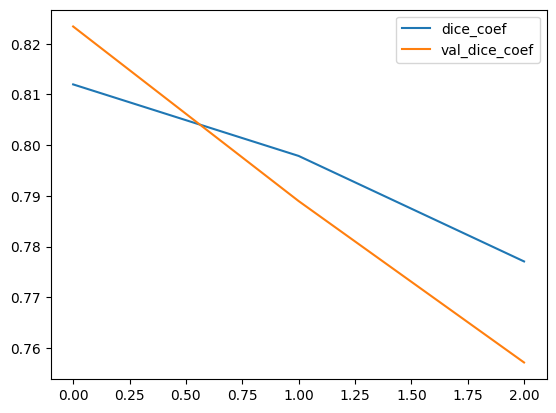

In [ ]:
with open('history_0.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [ ]:
model.load_weights('model_0.h5')

batch_pred_masks = model.predict_generator(
    check_generator,
    workers=1,
    verbose=1
)


<ipython-input-53-bce7ae367b8f>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  batch_pred_masks = model.predict_generator(


10/10 [==============================] - 2s 55ms/step


In [ ]:
for i in range(10):
    visualize(val_generator.getitem(i)[0][0,:,:,:],val_generator.getitem(i)[1][0,:,:,:],batch_pred_masks[i])

In [ ]:
model = vanilla_unet_crop((320, 480,3))

model.compile(optimizer=Nadam(lr=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 320, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_115 (Conv2D)            (None, 320, 480, 8)  224         ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_25 (MaxPooling2D  (None, 160, 240, 8)  0          ['conv2d_115[0][0]']             
 )                                                                                                
                                                                                            

In [ ]:
%%time
checkpoint = ModelCheckpoint('model_1.h5', save_best_only=True)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    epochs=3
)

<timed exec>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/3
 54/138 [==========>...................] - ETA: 4:44 - loss: 1.3208 - dice_coef: 0.8119

In [ ]:
with open('history_1.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [ ]:
model.load_weights('model_1.h5')

batch_pred_masks = model.predict_generator(
    check_generator,
    workers=1,
    verbose=1
)

In [ ]:
for i in range(10):
    visualize(val_generator.getitem(i)[0][0,:,:,:],val_generator.getitem(i)[1][0,:,:,:],batch_pred_masks[i])

In [ ]:
model = vanilla_unet_downscale((320, 480,3))

model.compile(optimizer=Nadam(lr=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 320, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_129 (Conv2D)            (None, 320, 480, 8)  224         ['input_7[0][0]']                
                                                                                                  
 conv2d_130 (Conv2D)            (None, 320, 480, 8)  584         ['conv2d_129[0][0]']             
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 160, 240, 8)  0          ['conv2d_130[0][0]']       

In [ ]:
%%time
checkpoint = ModelCheckpoint('model_2.h5', save_best_only=True)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    epochs=3
)

In [ ]:
with open('history_2.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [ ]:
model.load_weights('model_2.h5')

batch_pred_masks = model.predict_generator(
    check_generator,
    workers=1,
    verbose=1
)

In [ ]:
for i in range(10):
    visualize(val_generator.getitem(i)[0][0,:,:,:],val_generator.getitem(i)[1][0,:,:,:],batch_pred_masks[i])

In [ ]:
model = vanilla_unet_downscale_crop((320, 480,3))

model.compile(optimizer=Nadam(lr=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 320, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 320, 480, 8)  224         ['input_8[0][0]']                
                                                                                                  
 max_pooling2d_35 (MaxPooling2D  (None, 160, 240, 8)  0          ['conv2d_152[0][0]']             
 )                                                                                                
                                                                                            

In [ ]:
%%time
checkpoint = ModelCheckpoint('model_3.h5', save_best_only=True)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    epochs=3
)

In [ ]:
with open('history_3.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [ ]:
model.load_weights('model_3.h5')

batch_pred_masks = model.predict_generator(
    check_generator,
    workers=1,
    verbose=1
)

In [ ]:
for i in range(10):
    visualize(val_generator.getitem(i)[0][0,:,:,:],val_generator.getitem(i)[1][0,:,:,:],batch_pred_masks[i])

<Axes: >

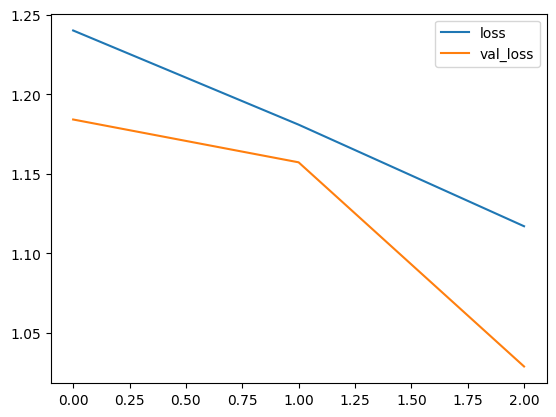

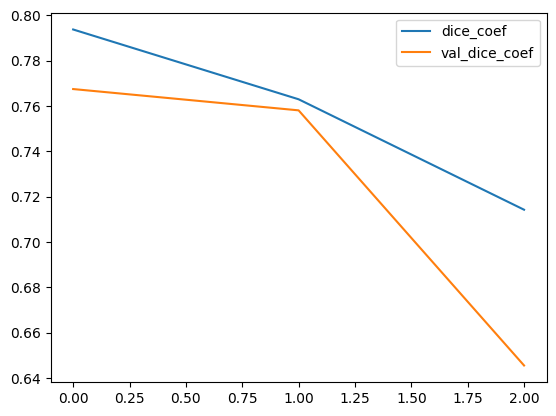

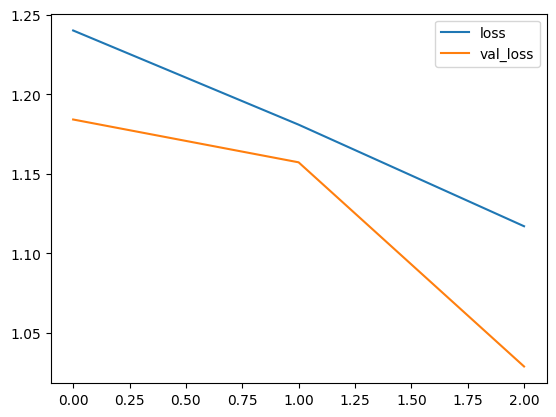

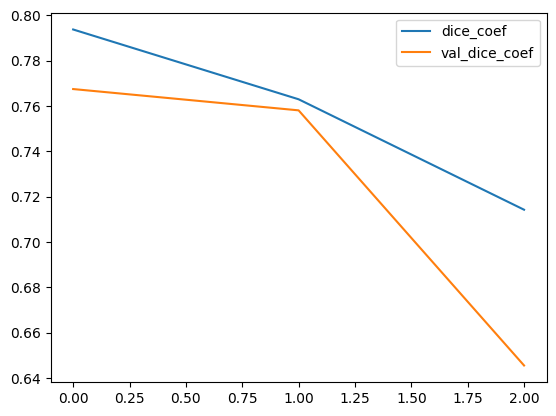

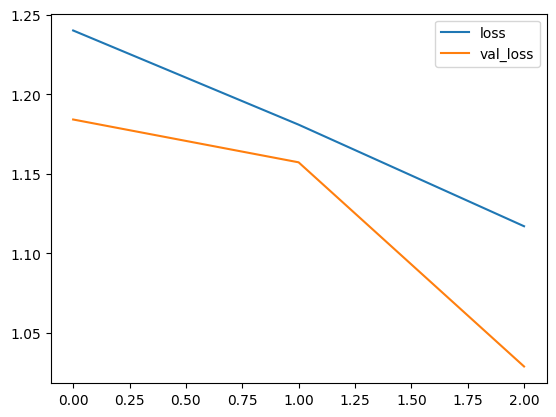

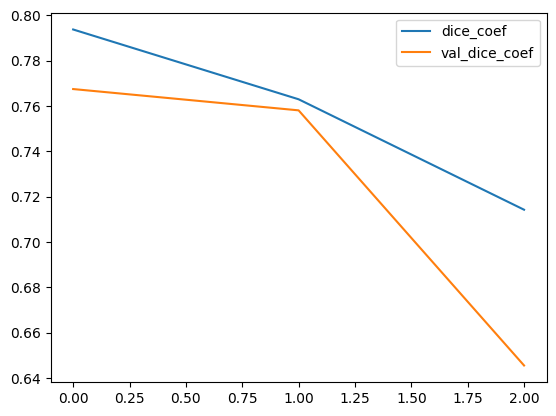

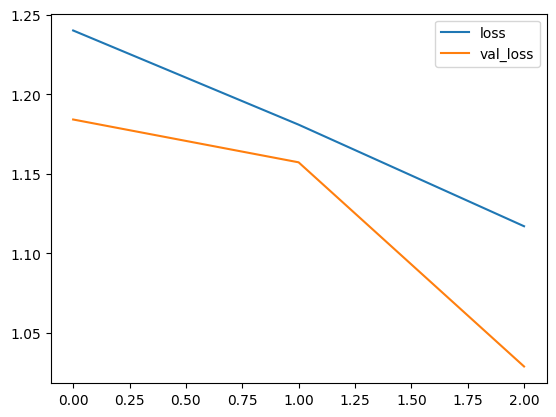

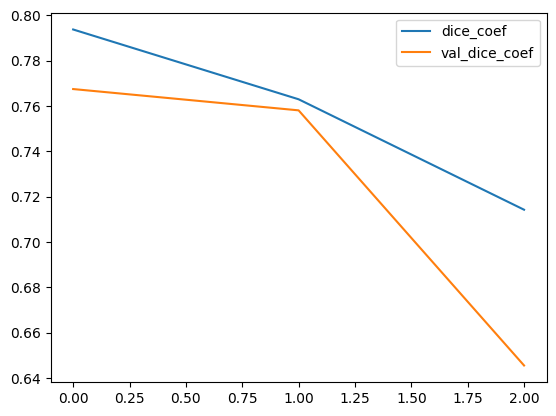

In [ ]:
with open('history_0.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

with open('history_1.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

with open('history_2.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

with open('history_3.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()